# Assignment III: Fine-Tuning of Language Models with QLoRA

In this third assignment we will continue to work with PyTorch and Open AI's early Open Source Model GPT2 to develop a deeper understanding and intuition of how language models are fine-tuned with parameter efficient fine tuning (PEFT) techniques. We will continue to look at a specific simple task, Sentiment Classification, and see how we can fine tune two different models to improve performance.

The structure of the Assignment is as follows:

1. **Fine-tuning of [GPT2 large](https://huggingface.co/openai-community/gpt2-large) with a sentiment classification dataset**  

   Here we will explore how we can combine Low Rank Adaptation (LoRA) with Quantization to fine tune a larger model.  We'll leverage the libaries from [Hugging Face](https://huggingface.co/docs/transformers/index) to use their AutoModel and AutoTokenizer classes as well as their Trainer class to fine tune a model to do sentiment classification. We'll experiment with some of the hyperparameters that affect LoRA performance to see what makes a positive or negative contribution.
   We will learn that the Huggingface infrastructure allows us to easily fine tune much larger models than we could normally fit on our compute resources.

2. **Fine-tuning of Gemma model for Sentiment Analysis**  
   We will then use a larger more recent model -- [Gemma 2](https://huggingface.co/google/gemma-2b) from Google -- to illustrate the benefits of an increase in the number of parameters and how it affects the performance of the model.  This model doubles the number or parameters but has also undergone a better pre-training regime and we would expect that to be reflected in the performance of the model.



For reference, please consider the Lecture material for weeks 2 - 5 as well as the two Special Session notebooks:

* Intro to PyTorch I (Basics)
* Intro to PyTorch II (Huggingface & Language Models)
* All lesson material and notebooks for Unit 5



**INSTRUCTIONS:**

* This notebook needs to be run using a GPU. If you use Google Colab, a T4 chip is the recommendation.
  
* Questions are always indicated as **QUESTION:**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the answers cells as you did in a1. Please do not remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.

* \### YOUR CODE HERE indicates that you are supposed to write code. All the way up to \### END YOUR CODE     

* **Important!!:** When you are done please re-run your notebook from beginning to end to that all of the seeds apply! This is very important!

**AUTOGRADER:**

- In each code block, do NOT delete the ### comment at the top of a cell (it's needed for the Gradescope grading!)
  - No autograder tests and results on this assignment.
  - You will get the full 42 points from the human graders for this assignment.
  - You may upload as many times as needed in your time window to get full points
  - The assignment needs to be named Assignment_3.ipynb to be graded from the autograder!
  - The examples given are samples of how we will test/grade your code.
    - Please ensure your code outputs the exact same information / format!
    - In addition to the given example, the autograder will test other examples
- Please format your input and output strings to be user friendly
- Adding comments in your code is strongly suggested but won't be graded.
- If you are stuck on a problem or do not understand a question - please come to office hours or ask questions (please don't post your code though). If it is a coding problem send a private email to your instructor.
- We also have a number of TA tutors for extra help and 1 on 1 sessions!
- You may use any libraries from the Python Standard Library for this assignment: https://docs.python.org/3/library/





## 0. Environment Setup

Let us first install a few required packages. (You may want to comment this out in case you use a local environment that already has the suitable packages installed.)

In [ ]:
%%capture

!pip install datasets==2.21.0
!pip install transformers
!pip install accelerate -U            # Quantization, Distribution
!pip install -q peft                  # LoRA
!pip install -q evaluate
!pip install bitsandbytes             # QLoRA

In [ ]:
import sys
import numpy as np
import torch

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BitsAndBytesConfig

from datasets import load_dataset, load_metric

from peft import LoraConfig, TaskType, PeftModel, get_peft_model
from peft import load_peft_weights, set_peft_model_state_dict
from peft import PromptEncoderConfig, prepare_model_for_kbit_training

import datasets
import random
import pandas as pd
from IPython.display import display, HTML

import wandb
wandb.init(mode="disabled")

Some useful definitions and functions we'll use (see Text Classification notebook):

In [ ]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def show_currently_allocated_gpu_mem():
  torch.cuda.empty_cache()
  mem = torch.cuda.memory_allocated()
  print(f"Current GPU memory allocation (GB): {mem/1024**3}")

## 1. Data Setup

We use the [GLUE dataset](https://gluebenchmark.com/), one of the original NLP "benchmarks", loading the data for the Stanford Sentiment Treebank task. We will also define the tokenizer for our first model (they all use the GPT2 tokenizer).

In [ ]:
task = actual_task = "sst2"

base_model_name = "gpt2-large"  # GPT2

batch_size = 16

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
dataset = load_dataset("glue", actual_task, trust_remote_code=True)
metric = load_metric('glue', actual_task, trust_remote_code=True)

To access an actual record, you need to select a split first, then give an index:

In [ ]:
dataset

Let's look at one record in the train split they provide.

In [ ]:
dataset["train"][2]

**QUESTION:**

1.a. How many records in the train split of the sst dataset we're using?

In [ ]:
### Q1-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

**QUESTION:**

1.b. How many records are in the test split of the sst dataset we're using?

In [ ]:
### Q1-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
show_random_elements(dataset["train"])

You can call the `compute` method associated with the glue benchmark, pass your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [ ]:
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

In [ ]:
sentence1_key, sentence2_key = ("sentence", None)

We need to take the text input and run it through the tokenizer to get input_ids, following (https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb).  We construct a properly formatted input for the Trainer class using the pre-process function defined above.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Lastly, we define for the future analysis the base model, the metric, and the key for the validation data in the encoded dataset:

In [ ]:
metric_name = "accuracy"

validation_key = "validation"

##2. QLoRA Setup

Now let's use QLoRA to fine-tune a model that is quantized down to a much smaller bit representation. We first need to specify the BitsAndBytes configuration, then the LoRA adapter, and then we'll train as always. But now we will use the [large model](https://huggingface.co/openai-community/gpt2-large) with 812 million parameters. That would **not** fit into our T4 chip for training purposes. It will work with QLoRA! How good will the results be?  Let find out.

First, your need to fill in the values of the BitsAndBytesConfig.

In [ ]:
bnb_config = BitsAndBytesConfig(
    ### YOUR CODE HERE


    ### END YOUR CODE
)

**QUESTION:**

1.c. What is our quantization goal - 16 bit, 8 bit or 4 bit?

In [ ]:
### Q1-c Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

Let's take advantage of Hugging Face's AutoModel classes.  We're doing classification so we're going to want the AutoModelForSequenceClassification class. They've already attached an output layer for us so we simply need to load the model weights and we can fine tune our classifier.

In [ ]:
qlora_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, quantization_config=bnb_config, device_map={"":0})

qlora_model.config.pad_token_id = qlora_model.config.eos_token_id

We can see the components of the model below. It tells us how the underlying decoder is structured.  You can see linear layer they've attached.  I generates two outputs -- one will be for positive e.g. 1 in the label and a second for negative e.g. 0 in the label.

In [ ]:
print(qlora_model)

**QUESTION:**

1.d. What kind of activation function is used in the MLP portion of the model?  RELU, LRELU, SPELU, or GELU?

In [ ]:
### Q1-d Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

Looking at the contents of model.config can also be very helpful.

In [ ]:
print(qlora_model.config)

Now let's see how much of the GPU memory is consumed by the model BEFORE we add in the adapter.

In [ ]:
show_currently_allocated_gpu_mem()

We need to do a few more adjustments:

In [ ]:
qlora_model.gradient_checkpointing_enable()
qlora_model = prepare_model_for_kbit_training(qlora_model)


Now, very importantly, we need to set the size of our adapter.  Specifically we need to set the value of the rank and the alpha.  You can read about the purpose of these values in [this excellent blog](https://www.determined.ai/blog/lora-parameters) about fine-tuning with LoRA.

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

qlora_model = get_peft_model(qlora_model, config)
qlora_model.print_trainable_parameters()

In [ ]:
qlora_model(**tokenizer('this is fun', return_tensors='pt').to('cuda'))['logits']

Now, let's see how much memory the LoRA adapter is using.  By looking at the difference between the GPU memory allocation before and after we can see how much space the adapter is using.

In [ ]:
show_currently_allocated_gpu_mem()

Now we need to configure the Hugging Face Trainer.  This involves filling out the Training Arguments structure so we can pass it on the to Trainer class when we instntiate it.  As indicated in the blog you need to find a good learning rate that will allow you to get an evaluation accuracy above 0.92.  You can experiment with multiple values.  Once you find a good one you can shift to finding good r and alpha values.

In [ ]:
## Training Arguments structure
args = TrainingArguments(
    f"qlora_{base_model_name}-finetuned-{task}",
    eval_strategy = "steps",
    eval_steps = 100,
    save_strategy = "no",
    logging_strategy = "steps",
    logging_steps = 100,
    learning_rate=1,                   ### YOUR EXPERIMENT VALUE HERE!
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    max_steps=300,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
)


## Trainer we'll use to fine tune
qlora_trainer = Trainer(
    qlora_model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



Now that we have configured the trainer we can easily train the model by simply calling trainer.train()



In [ ]:
qlora_trainer.train()

Let's evaluate the trainer against our validation test set and see how well our model is performing.  The trainer class simplifies the evaluation process as well.  Your goal is to get an 'eval_accuracy' above 0.92 by manipulating the values for r, lora alpha, and the learning rate.

In [ ]:
qlora_trainer.evaluate()

**QUESTION:**

1.e. What is the value of the learning rate that allows you to get an evaluation accuracy above 0.92?

In [ ]:
### Q1-e Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

**QUESTION:**

1.f. What is the r value of your LoRA adapter that lets you get an evaluation accuracy above 0.92?

In [ ]:
### Q1-f Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

**QUESTION:**

1.g. What is the r-alpha value of your LoRA adapter that lets you get an evaluation accuracy above 0.92?

In [ ]:
### Q1-g Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

Be very careful using this as it will clean out memory.  Only use it once you've identified the values you're happy with in fine-tuning GPT2 and you're ready to move on to the next model.

In [ ]:
del qlora_trainer

## 3. Larger Model Data Setup

Now let's try running the same data through a more recent model, specifically Gemma2 from Google.  You can check out [the model card](https://huggingface.co/google/gemma-2-2b) -- always a good idea or the [Technical Report](https://arxiv.org/pdf/2408.00118). We again need to define the tokenizer for our second model so we can reprocess the data.

In order to use this model you will need to identify yourself to HuggingFace. If you don't already have an account with Hugging Face, you should get one.  You can then log in to the Hugging Face site and from there go to [the model card](https://huggingface.co/google/gemma-2-2b) and request access to the Gemma model.  Once you are granted access -- usually a matter of minutes -- you will see something like the following when you visit the model card:

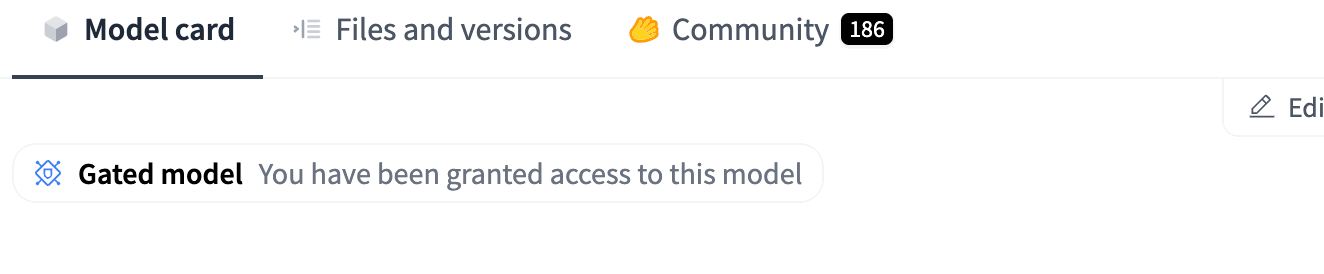

In [ ]:
task = actual_task = "sst2"
large_model_name = "google/gemma-2-2b"
batch_size = 16

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(large_model_name, use_fast=True,)
tokenizer.pad_token = tokenizer.eos_token

We're using a new model and it has its own tokenizer so we need to reprocess the data with that new tokenizer.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Lastly, we define for the future analysis the metric and the key for the validation data in the encoded dataset:

In [ ]:
metric_name = "accuracy"

validation_key = "validation"

##4. Larger QLoRA Setup

Now let's use QLoRA to fine-tune a model that is quantized down to a much smaller number of bits. We first need to specify the BitsAndBytes configuration, then the LoRA adapter, and then we'll train. But now we will use a very recent LLM [and larger model](https://huggingface.co/google/gemma-2-2b) with 2.61 billion parameters. That would **not** fit into our T4 chip for training purposes. It will work with QLoRA. And how good it be relative to the GPT2 model we fine-tuned first?

First you need to fill in the BitsAndBytesConfig file again.

In [ ]:
bnb_config = BitsAndBytesConfig(
    ### YOUR CODE HERE


    ### END YOUR CODE
)

Let's take advantage of Hugging Face's AutoModel classes.  We're doing classification so again we'll use the AutoModelForSequenceClassification. They've already attached an output layer for us so we simply need to load the model weights.

In [ ]:
lqlora_model = AutoModelForSequenceClassification.from_pretrained(large_model_name, quantization_config=bnb_config, device_map={"":0})

lqlora_model.config.pad_token_id = lqlora_model.config.eos_token_id

We can see the components of the model below. It tells us how the underlying decoder is structured.  You can see

In [ ]:
print(lqlora_model)

Looking t the contents of model.config can also be very helpful.

In [ ]:
print(lqlora_model.config)

Now that we've loaded the Gemma model into memory let's see what size footprint it has.

In [ ]:
show_currently_allocated_gpu_mem()

We need to do a few more adjustments to take advantge of the model:

In [ ]:
lqlora_model.gradient_checkpointing_enable()
lqlora_model = prepare_model_for_kbit_training(lqlora_model)


Now you can experiment a bit with the values for r, lora_alpha, and the learning rate.  For staters try using the values you landed upon when you were fine-tuning GPT2-large.

In [ ]:
lconfig = LoraConfig(
    r=0,             ###### YOUR VALUE HERE
    lora_alpha=0,    ###### YOUR VALUE HERE
    lora_dropout=0,  ###### YOUR VALUE HERE
    bias="none",
    task_type="SEQ_CLS"
)

lqlora_model = get_peft_model(lqlora_model, lconfig)
lqlora_model.print_trainable_parameters()

**QUESTION:**

1.h. What is the r value of your LoRA adapter that lets you get an evaluation accuracy above 0.95?

In [ ]:
### Q1-h Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

**QUESTION:**

1.i. What is the r-alpha value of your LoRA adapter that lets you get an evaluation accuracy above 0.95?

In [ ]:
### Q1-i Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

In [ ]:
#qlora_model.to('cuda')
lqlora_model(**tokenizer('this is fun', return_tensors='pt').to('cuda'))['logits']

**QUESTION:**

1.j. What is the number of trainable parameters in the QLoRA model for Gemma-2-2B?

In [ ]:
### Q1-j Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

In [ ]:
show_currently_allocated_gpu_mem()

In [ ]:
largs = TrainingArguments(
    f"lqlora_{large_model_name}-finetuned-{task}",
    eval_strategy = "steps",
    eval_steps = 100,
    save_strategy = "no",
    logging_strategy = "steps",
    logging_steps = 100,
    learning_rate=0,                ####### YOUR VALUE HERE
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    max_steps=300,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

lqlora_trainer = Trainer(
    lqlora_model,
    largs,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



**QUESTION:**

1.k. What is the learning rate you are using for the larger QLoRA model to get a validation accuracy above 0.95?

In [ ]:
### Q1-k Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

Now that we have configured the trainer we can easily train the model by simply calling trainer.train()



In [ ]:
lqlora_trainer.train()

Let's evaluate the trainer against our validation test set and see how well our model is performing.  The trainer class simplifies the evaluation process as well.

In [ ]:
lqlora_trainer.evaluate()

**QUESTION:**

1.l. What is the final evaluation accuracy you get on the larger model?
 (Must be above 0.95)

In [ ]:
### Q1-l Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE

### END YOUR ANSWER

Okay, youre done with assignment III.  Hopefully you've had a gentle introduction to using quantization and LoRA to fine tune different decoder based models.